# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#no warnings about floating precision
import warnings
warnings.filterwarnings('ignore')

In [3]:
# LIMIT GPU MEMORY TAKEN UP BY THE NOTEBOOK
# you can specify the fraction of the AVAILABLE GPU memory that will be
# pre-allocated (jax default is .9)

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.9'
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

#use another GPU if the default one is occupied
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
import jax
import jax.numpy as np

from jax.random import split, PRNGKey
from jax import lax

jax.config.update('jax_debug_nans', True)

### NOTE: f32 gives > 3x speedup wrt f64
#config.update('jax_enable_x64', True)

#use this line to set the device to be used for the computations
#print(jax.devices())
#DOES NOT RECOGNIZE THE OPTION NAME FTM
#jax.config.update('jax_default_device', jax.devices()[1])

import equinox as eqx

import haiku as hk

from functools import partial

In [5]:
import jax_md
from jax_md import space

import jax_md.dataclasses as jdc

In [6]:
import jax_morph
from jax_morph.utils import _maybe_array

from jax_morph.visualization import draw_circles_ctype, draw_circles_chem, draw_circles_divrate

from jax_morph.datastructures import SpaceFunc 
from jax_morph.simulation import simulation, sim_trajectory

from jax_morph.division_and_growth.cell_division import S_cell_division
from jax_morph.division_and_growth.cell_growth import S_grow_cells

from jax_morph.mechanics.morse import S_mech_morse_relax
from jax_morph.chemicals.secdiff import S_ss_chemfield

from jax_morph.cell_internals.divrates import S_set_divrate, div_nn
from jax_morph.cell_internals.secretion import sec_nn
from jax_morph.cell_internals.grad_estimate import S_chemical_gradients

from chem_twotypes.initial_states import init_state_grow

ModuleNotFoundError: No module named 'chem_twotypes'

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20})

from tqdm import tqdm

# Set Parameters

In [ ]:
ParamsDict = dict

In [ ]:
# Define parameters -- blue particles are type 1, orange are type 2
# keep jax type casting to place vars in gpu memory

n_dim = 2

# Number of chemical signals
n_chem = 2
n_celltype = 1

#-------------------------------------------------------------------------------
### NEW CLEAN VERSION




### CELL DIMENSIONS

#change constants in divrate calculation if cellRad != .5 
# always use python scalars
cellRad = .5
cellRadBirth = float(cellRad / np.sqrt(2))


### DIFFUSION

#possibly different diffusion and degradation for each chemical
diffCoeff = np.ones(n_chem) #np.linspace(.5,n_chem/2+1,n_chem) # #np.array([1.,3.]) #np.ones(n_chem)
degRate = np.ones(n_chem) #np.array([1.,1.])

#diffusion cutoff
r_cutoffDiff = 5.*cellRad
r_onsetDiff = r_cutoffDiff - .5


### SECRETION

# sec rate that gives concentration 1 at source at SS
sec_max_unitary = 2*np.sqrt(diffCoeff*degRate)

sec_max = np.ones((n_chem,), dtype=np.float32)
#sec_max = sec_max.at[0].set(20.)
#sec_max = sec_max.at[1].set(2.)

# SECRETION 

#rows are ctypes, cols are chemicals
#1 if ct secretes chem, 0 otw
#needs to be array for indexing

#ctype_sec_chem = np.identity(n_chem, dtype=np.int16) #each ct secretes one chem
ctype_sec_chem = np.ones((n_celltype,n_chem), dtype=np.int16) #every ct secretes everything
#ctype_sec_chem = np.hstack([np.identity(2)])


# sec_gamma = .5* np.ones((n_chem,n_chem), dtype=np.float32) #was 0.01
# sec_k = 1.*np.ones((n_chem,n_chem), dtype=np.float32) 


# # DIVISION

# div_gamma = 2.*np.ones(n_chem, dtype=np.float32)
# div_k = 1.*np.ones(n_chem, dtype=np.float32)
# div_k = div_k.at[0].set(3.)


# MORSE POTENTIAL
# always use python scalars
alpha = 3.
epsilon = 3.
# eps_OneOne = 3. #blue
# eps_TwoTwo = 3. #orange
# eps_OneTwo = 3. 

#morse cutoff
r_cutoff = 5*cellRad
r_onset = r_cutoff - .2


# number of gradient descent steps for potential minimization
mech_relaxation_steps = 10


# Initialization and number of added cells. 
ncells_init = 2 #number of cells in the initial cluster
n_ones_init = ncells_init #number of type-1 cell in the initail cluster
ncells_add = 138
#ncells_tot =  np.int16(ncells_init+ncells_add)# final number of cells

#assert ncells_init > n_ones_init

In [ ]:
train_params = {
    'n_dim': False,
    'n_chem': False,
    #'secreted_by_ctypes': False,
    'ctype_sec_chem': False,
    
    'sec_max': True,
    
    # 'sec_gamma': False,
    # 'sec_k' : False,
    
    # 'div_gamma' : False,
    # 'div_k' : False,
    
    'cellRad' : False,
    'cellRadBirth' : False,
    
    'diffCoeff' : True,
    'degRate' : False,
    'r_onsetDiff' : False,
    'r_cutoffDiff' : False,
    
    'alpha': False, 
    'epsilon': False,
    # 'eps_TwoTwo': False, 
    # 'eps_OneOne' : False,
    # 'eps_OneTwo' : False,
    'r_onset' : False,
    'r_cutoff' : False,
    'mech_relaxation_steps' : False,
    
    'ncells_init' : False,
    'n_ones_init': False, 
    #'ncells_tot': ncells_tot,
    'ncells_add': False,
}

In [ ]:
params = {
    'n_dim': n_dim,
    'n_chem': n_chem,
    #'secreted_by_ctypes': sec_by_ctypes,
    'ctype_sec_chem': ctype_sec_chem,
    
    'sec_max': sec_max,
    # 'sec_gamma': sec_gamma,
    # 'sec_k' : sec_k,
    
    # 'div_gamma' : div_gamma,
    # 'div_k' : div_k,
    
    'cellRad' : cellRad,
    'cellRadBirth' : cellRadBirth,
    
    'diffCoeff' : diffCoeff,
    'degRate' : degRate,
    'r_onsetDiff' : r_onsetDiff,
    'r_cutoffDiff' : r_cutoffDiff,
    
    'alpha': _maybe_array('alpha', alpha, train_params),
    'epsilon': _maybe_array('epsilon', epsilon, train_params),
    # 'eps_TwoTwo': _maybe_array('eps_TwoTwo', eps_TwoTwo, train_params), 
    # 'eps_OneOne' : _maybe_array('eps_OneOne', eps_OneOne, train_params),
    # 'eps_OneTwo' : _maybe_array('eps_OneTwo', eps_OneTwo, train_params),
    'r_onset' : r_onset,
    'r_cutoff' : r_cutoff,
    'mech_relaxation_steps' : mech_relaxation_steps,
    
    'ncells_init' : ncells_init,
    'n_ones_init': n_ones_init, 
    #'ncells_tot': ncells_tot,
    'ncells_add': ncells_add,
}



#ip, hp = eqx.partition(params, train_params)

# State dataclass

**Note:**
- HYPERPARAMETERS: 
Shape parameters needed to correctly initialize the datastructures in the actual system state below. Needed to be able to initialize the system state.

- STATE:
All of the fields that are needed to keep track of the actual system state. Should be initialized automatically with the default values, given the shape parameters above.

In [ ]:
# decorator MUST be jax_md.dataclass instead of dataclasses.dataclass
# to make dataclass compatible with jax tree operations
@jdc.dataclass
class CellState:
    '''
    Dataclass containing the system state.

    STATE
    -----
    position: jax_md.util.Array
        Positions of cells.
    celltype: jax_md.util.Array
        Cell types.
    radius: jax_md.util.Array
        Cell radii.
    chemical: jax_md.util.Array
        Chemical concentrations.
    chemgrad: jax_md.util.Array
        Chemical gradients.
    divrate: jax_md.util.Array
        Division rates.
    key: jax_md.util.Array
        Random number generator key.
    '''

    # STATE
    position:   jax_md.util.Array
    celltype:   jax_md.util.Array
    radius:     jax_md.util.Array
    chemical:   jax_md.util.Array
    chemgrad:   jax_md.util.Array
    divrate:    jax_md.util.Array
    key:        jax_md.util.Array


    @classmethod
    def default_init(cls, n_dim=2, n_chem=1):
        '''
        Intializes a CellState with no cells (empty data structures, with correct shapes).
        

        Parameters
        ----------
        n_dim: int
            Number of spatial dimensions.
        n_chem: int
            Number of chemical species.

        Returns
        -------
        CellState
        '''

        assert n_dim == 2 or n_dim == 3, 'n_dim must be 2 or 3'
        assert n_chem > 0 and isinstance(n_chem, int), 'n_chem must be a positive integer'
        
        defaultstate = {
            'position'  :   np.empty(shape=(0, n_dim),              dtype=np.float32),
            'celltype'  :   np.empty(shape=(0,),                    dtype=np.int8),
            'radius'    :   np.empty(shape=(0,),                    dtype=np.float32),
            'chemical'  :   np.empty(shape=(0, n_chem),             dtype=np.float32),
            'chemgrad'  :   np.empty(shape=(0, int(n_dim*n_chem)),  dtype=np.float32),
            'divrate'   :   np.empty(shape=(0,),                    dtype=np.float32),
            'key'       :   None,
        }


        return cls(**defaultstate)

# Simulation

In [ ]:
key = PRNGKey(0)

## Generate initial state

In [ ]:
# build initial state and space handling functions

fspace = SpaceFunc(*space.free())

key, init_key = split(key)

N_CELLS_INIT = params['ncells_init']

#generate empty data structure with correct shapes
istate = CellState.default_init(n_dim=params['n_dim'], n_chem=params['n_chem'])

# populate initial state by growing from single cell
istate = init_state_grow(init_key, istate, params, fspace, N_CELLS_INIT)

## Initialize ANNs

In [ ]:
use_state_fields = CellState(position=   False, 
                             celltype=   False, 
                             radius=     False, 
                             chemical=   True,
                             chemgrad=   True,
                             divrate=    False, 
                             key=        False
                            )

# init division nn
DIV_HIDDEN = [4]#*2

div_init, div_nn_apply = div_nn(params,train_params,DIV_HIDDEN,use_state_fields,train=True)


key, init_key = split(key)
params, train_params = div_init(istate, init_key)

In [ ]:
use_state_fields = CellState(position=   False, 
                             celltype=   False, 
                             radius=     False, 
                             chemical=   True,
                             chemgrad=   True,
                             divrate=    False, 
                             key=        False
                            )

#init secretion nn
SEC_HIDDEN = [64]#*2

sec_init, sec_nn_apply = sec_nn(params,train_params,SEC_HIDDEN,use_state_fields,train=True)

key, init_key = split(key)
params, train_params = sec_init(istate, init_key)

## Generate init-apply functions

In [ ]:
# functions in this list will be executed in the given order
# at each simulation step

fstep = [
    # ENV CHANGES
    S_cell_division,
    S_grow_cells,
    S_mech_morse_relax,
    partial(S_ss_chemfield, sec_fn=sec_nn_apply, n_iter=3),

    # SENSING
    #chemicals sensed directly
    S_chemical_gradients,

    # INTERNAL (HIDDEN) STATE

    # POLICIES
    partial(S_set_divrate, divrate_fn=eqx.filter_jit(div_nn_apply))
]


sim_init, sim_step = simulation(fstep, params, fspace)

# Run simulation

In [7]:
fstate, _ = sim_trajectory(istate, sim_init, sim_step, 100, init_key)

NameError: name 'istate' is not defined

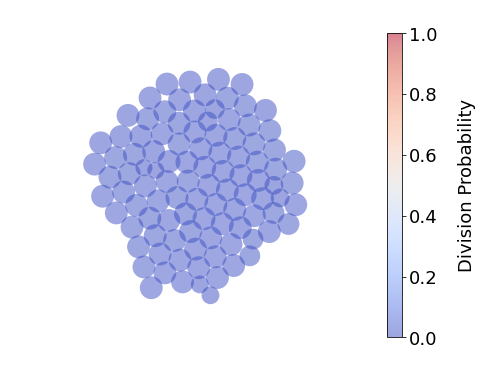

In [105]:
draw_circles_divrate(fstate);

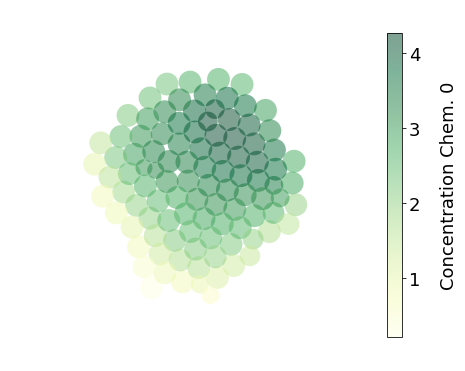

In [106]:
fig, ax = draw_circles_chem(fstate,0)

# Optimization

In [21]:
from jax import vmap, value_and_grad

import optax
from optax import adam, sgd

from jax_morph.optimization.losses import reinforce_loss, avg_loss, simple_loss
from jax_morph.optimization.state_metrics import diff_n_ctypes

## Shape metrics

In [22]:
def tunnel_metric(state, width=4.):
    '''
    Costrain cell growth in a vertical "tunnel".
    '''
    
    # eigv = np.linalg.eigvalsh(np.cov(state.position, rowvar=False))
    
    #DIFFERENCE
    # eigv_diff = np.sqrt((eigv[0]-eigv[1])**2)
    # m=eigv_diff
    
    #ENTROPY
    # eigv_h = eigv/eigv.sum()
    # eigv_h = -np.sum(eigv_h*np.log(eigv_h))
    # m=eigv_h
    
    ### SUM OF X
    #m = np.sqrt(np.mean(np.power(state.position[:,0],2)))#-np.sqrt(np.mean(np.power(state.position[:,1],2)))
    
    p = np.sum(np.where(np.abs(state.position[:,0])<width/2,-1.,2)*np.where(state.celltype>0,1,0))
    
    #r = np.sum(np.where((np.abs(state.position[:,0])<2.) * (np.abs(state.position[:,1])>3.),-4,0)*np.where(state.celltype>0,1,0))
    
    r=0.
    
    m = (p+r)/np.where(state.celltype>0,1,0).sum()

    # m = state.chemical[:,0]*np.where(state.celltype>0,1,0)
    # m = m.mean()
    
    return m

In [23]:
def v_metric(state):
    '''
    Costrain cell growth in a V shape.
    '''
    
    
    p = np.sum(np.where(state.position[:,1] > np.abs(state.position[:,0]),-1.,2)*np.where(state.celltype>0,1,0))
    #p += np.sum(np.where(state.position[:,1]/np.abs(state.position[:,0])>3.,3.,0.)*np.where(state.celltype>0,1,0))
    
    #r = np.sum(np.where((np.abs(state.position[:,0])<2.) * (np.abs(state.position[:,1])>3.),-4,0)*np.where(state.celltype>0,1,0))
    
    r=0.
    
    m = (p+r)/np.where(state.celltype>0,1,0).sum()

    # m = state.chemical[:,0]*np.where(state.celltype>0,1,0)
    # m = m.mean()
    
    return m

In [24]:
def x_metric(state):
    '''
    Costrain cell growth in a X-shaped "tunnel".
    '''
    
    mask = (state.position[:,1] > (state.position[:,0]-1)) * (state.position[:,1] < (state.position[:,0]+1))
    mask = mask + (state.position[:,1] > (-state.position[:,0]-1)) * (state.position[:,1] < (-state.position[:,0]+1))
    
    m = np.sum(np.where(mask,-1.,2)*np.where(state.celltype>0,1,0))

    #m = m/np.where(state.celltype>0,1,0).sum()
    
    return m

In [25]:
def elongation_metric(state):
    '''
    Evaluate asymmetry of cell growth.
    '''
    
    eig, A = np.linalg.eigh(np.cov(state.position.T))

    pos_aligned = state.position @ A
    
    p = np.sum(np.where(np.abs(pos_aligned[:,0])<2.,-1.,2)*np.where(state.celltype>0,1,0))
    
    
    m = p/np.where(state.celltype>0,1,0).sum()

    # m = state.chemical[:,0]*np.where(state.celltype>0,1,0)
    # m = m.mean()
    
    return m

In [26]:
def elongation_metric(state):
    '''
    Evaluate asymmetry of cell growth.
    '''
    
    m = np.sum((state.position[:,1]**2)*np.where(state.celltype>0,1,0))
    
    m = m/np.where(state.celltype>0,1,0).sum()
    
    return m

In [27]:
def circle_metric(state, R=2.):
    return np.sum(np.where((state.position**2).sum(1)<R**2, -1, 2)*np.where(state.celltype>0,1,0))

In [28]:
def ring_metric(state, R=10., width=3.): #1.5, 3
    '''
    Costrain cell growth in a circular ring "tunnel".
    '''
    
    X0 = -(R+width/2) #x coord of the center
    
    sum_sq = (state.position[:,0]-X0)**2 + state.position[:,1]**2
    
    mask = (sum_sq>R**2)*(sum_sq<(R+width)**2)
    
    m = np.sum(np.where(mask, -1, 2)*np.where(state.celltype>0,1,0))
    
    #m = m/np.where(state.celltype>0,1,0).sum()
    
    return m

In [29]:
def triangle_metric(state, high_lim=6.):
    '''
    Costrain cell growth in a V shape.
    '''
    
    mask = (state.position[:,1]>state.position[:,0])*(state.position[:,1]>-state.position[:,0])*(state.position[:,1]<high_lim)
    
    p = np.sum(np.where(mask,-1.,2)*np.where(state.celltype>0,1,0))
    #p += np.sum(np.where(state.position[:,1]/np.abs(state.position[:,0])>3.,3.,0.)*np.where(state.celltype>0,1,0))
    
    #r = np.sum(np.where((np.abs(state.position[:,0])<2.) * (np.abs(state.position[:,1])>3.),-4,0)*np.where(state.celltype>0,1,0))
    
    r=0.
    
    m = (p+r)/np.where(state.celltype>0,1,0).sum()

    # m = state.chemical[:,0]*np.where(state.celltype>0,1,0)
    # m = m.mean()
    
    return m

In [30]:
def plus_metric(state, max_norm=3.):
    '''
    Costrain cell growth in a vertical "tunnel".
    '''

    mask = np.bool_((np.abs(state.position[:,0])<1.5)+(np.abs(state.position[:,1])<1.5))*(np.linalg.norm(state.position,2,1)<max_norm**2)
    
    m = np.sum(np.where(mask,-1.,2)*np.where(state.celltype>0,1,0))
    
    #m = p/np.where(state.celltype>0,1,0).sum()
    
    return m

## Reinforce loss

In [31]:
@eqx.filter_jit
@eqx.filter_vmap(default=None, kwargs=dict(sim_key=0))
def shape_loss_fr(params, 
            hyper_params,
            fstep,
            fspace,
            istate,
            sim_key=None,
            metric_fn=None,
            target_metric=0.,
            REINFORCE=True,
            GAMMA=.95,
            TEST=False,
           ):
    '''
    REINFORCE loss with discounting.  
    '''
    
    def _sim_trajectory(istate, sim_init, sim_step, ncells_add, key=None):

        state = sim_init(istate, ncells_add, key)

        def scan_fn(state, i):
            state, logp = sim_step(state)
            loss = np.sum((metric_fn(state) - target_metric)**2)
            loss = np.sqrt(loss)
            return state, (logp, loss)


        iterations = len(state.celltype)-len(istate.celltype)
        iterations = np.arange(iterations)
        fstate, aux = lax.scan(scan_fn, state, iterations)

        return fstate, aux

    # merge params dicts
    all_params = eqx.combine(params, hyper_params)
    
    #simulation length
    ncells_add = all_params['ncells_add']


    #forward pass - simulation
    sim_init, sim_step = simulation(fstep, all_params, fspace)
    fstate, (logp, losses) = _sim_trajectory(istate, sim_init, sim_step, ncells_add, sim_key)


    
    if REINFORCE:
        
        def _returns_rec(losses):
            Gs=[]
            G=0
            i=0
            for l in losses[::-1]:
                G = l+G*GAMMA
                Gs.append(G)
                i += 1

            return np.array(Gs)[::-1]
        
        iloss = np.sqrt(np.sum((metric_fn(istate) - target_metric)**2))
        rewards = -np.diff(np.append(np.array([iloss]),losses))
        
        #discount rewards
        returns = _returns_rec(rewards)
        
        loss = -np.sum(logp*lax.stop_gradient(returns))#+rewards.sum()
        
        return loss
    
    if TEST:
        return losses, rewards, logp

    else:
        return losses[-1]

In [32]:
@eqx.filter_jit
@eqx.filter_vmap(default=None, kwargs=dict(sim_key=0))
def shape_loss_reg(params, 
            hyper_params,
            fstep,
            fspace,
            istate,
            sim_key=None,
            metric_fn=None,
            target_metric=0.,
            REINFORCE=True,
            GAMMA=.95,
            TEST=False,
            LAMBDA=.01,
           ):
    '''
    REINFORCE loss with discounting.  
    '''
    
    def _sim_trajectory(istate, sim_init, sim_step, ncells_add, key=None):

        state = sim_init(istate, ncells_add, key)

        def scan_fn(state, i):
            state, logp = sim_step(state)
            loss = np.sum((metric_fn(state) - target_metric)**2)
            loss = np.sqrt(loss)
            return state, (logp, loss)


        iterations = len(state.celltype)-len(istate.celltype)
        iterations = np.arange(iterations)
        fstate, aux = lax.scan(scan_fn, state, iterations)

        return fstate, aux

    # merge params dicts
    all_params = eqx.combine(params, hyper_params)
    
    #simulation length
    ncells_add = all_params['ncells_add']


    #forward pass - simulation
    sim_init, sim_step = simulation(fstep, all_params, fspace)
    fstate, (logp, losses) = _sim_trajectory(istate, sim_init, sim_step, ncells_add, sim_key)

    reg = np.array(jax.tree_leaves(jax.tree_map(lambda x: np.sum(x**2), params['div_fn']))).sum()
    reg += np.array(jax.tree_leaves(jax.tree_map(lambda x: np.sum(x**2), params['sec_fn']))).sum()
    
    
    if REINFORCE:
        
        def _returns_rec(losses):
            Gs=[]
            G=0
            i=0
            for l in losses[::-1]:
                G = l+G*GAMMA
                Gs.append(G)
                i += 1

            return np.array(Gs)[::-1]
        
        iloss = np.sqrt(np.sum((metric_fn(istate) - target_metric)**2))
        rewards = -np.diff(np.append(np.array([iloss]),losses))
        
        #discount rewards
        returns = _returns_rec(rewards)
        
        loss = -np.sum(logp*lax.stop_gradient(returns))#+rewards.sum()
        
        return loss + LAMBDA*reg
    
    if TEST:
        return losses, rewards, logp

    else:
        return losses[-1]

## Optimization loop

In [107]:
EPOCHS = 100
EPISODES_PER_UPDATE = 16 #128
EPISODES_PER_EVAL = 96 #128

LEARNING_RATE = 5e-3
#LEARNING_RATE = optax.warmup_cosine_decay_schedule(init_value=1e-3, peak_value=5e-3, warmup_steps=int(EPOCHS*.2), decay_steps=EPOCHS, end_value=7e-4)


METRIC_FN = elongation_metric
TARGET_METRIC = 0#-1.#-ncells_add


rloss = partial(shape_loss_reg, metric_fn=METRIC_FN, target_metric=TARGET_METRIC, REINFORCE=True)
sloss = partial(shape_loss_reg, metric_fn=METRIC_FN, target_metric=TARGET_METRIC, REINFORCE=False)


p, hp = eqx.partition(params, train_params)

# init optimizer



optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(p)


#--------------------------------------------
#store loss at initial params and calc grad 

key, *batch_subkeys = split(key, EPISODES_PER_UPDATE+1)
batch_subkeys = np.array(batch_subkeys)

ll, grads = value_and_grad(avg_loss)(p, hp, rloss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)


key, *eval_subkeys = split(key, EPISODES_PER_EVAL+1)
eval_subkeys = np.array(eval_subkeys)

l = avg_loss(p, hp, sloss, eval_subkeys, fstep=fstep, fspace=fspace, istate=istate)

#store initial params and loss
loss_t = [float(l)]
params_t = [p]
#rloss_t = [float(ll)]

#print(grads['div_fn']['mlp/~/linear_0']['b'])

#grads_t = [grads]

#--------------------------------------------


for t in tqdm(range(EPOCHS), total=EPOCHS):
    
    #generate batch of random keys
    key, *batch_subkeys = split(key, EPISODES_PER_UPDATE+1)
    batch_subkeys = np.array(batch_subkeys)
        
    #normalize grads
    #grads = jax.tree_map(lambda x: x/np.sqrt(np.sum(x**2)), grads)
    #grads = jax.tree_map(lambda x: -x, grads)
    
    # sgd step
    updates, opt_state = optimizer.update(grads, opt_state, p)

    p = eqx.apply_updates(p, updates)
    
    if None != p['diffCoeff']:
        p['diffCoeff'] = np.where(p['diffCoeff']>.2,p['diffCoeff'],.2)
    
    #estimate actual avg loss
    key, *eval_subkeys = split(key, EPISODES_PER_EVAL+1)
    eval_subkeys = np.array(eval_subkeys)

    l = avg_loss(p, hp, sloss, eval_subkeys, fstep=fstep, fspace=fspace, istate=istate)
    #print('Loss:\t', float(l))
    
    # surrogate loss and grads
    ll, grads = value_and_grad(avg_loss)(p, hp, rloss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)

    #print(grads['div_fn']['mlp/~/linear_0']['b'])

    #store
    loss_t += [float(l)]
    #rloss_t.append(float(ll))
    params_t += [p]
    #grads_t += [grads]
    
    if 0 == t%5:
        print(float(l))
    

  1%|          | 1/100 [00:03<05:28,  3.31s/it]

7.777057647705078


  6%|▌         | 6/100 [00:14<03:45,  2.40s/it]

7.116859436035156


 11%|█         | 11/100 [00:26<03:27,  2.33s/it]

7.02162504196167


 16%|█▌        | 16/100 [00:38<03:14,  2.32s/it]

6.902096748352051


 21%|██        | 21/100 [00:49<03:03,  2.32s/it]

6.99301815032959


 26%|██▌       | 26/100 [01:01<02:51,  2.32s/it]

7.06891393661499


 31%|███       | 31/100 [01:13<02:40,  2.33s/it]

6.979228973388672


 36%|███▌      | 36/100 [01:24<02:29,  2.34s/it]

6.853267669677734


 41%|████      | 41/100 [01:36<02:17,  2.34s/it]

6.838645935058594


 46%|████▌     | 46/100 [01:48<02:06,  2.34s/it]

6.907675743103027


 51%|█████     | 51/100 [01:59<01:55,  2.35s/it]

6.7239813804626465


 56%|█████▌    | 56/100 [02:11<01:42,  2.34s/it]

6.6954498291015625


 61%|██████    | 61/100 [02:23<01:31,  2.33s/it]

6.742913722991943


 66%|██████▌   | 66/100 [02:34<01:19,  2.34s/it]

6.717225551605225


 71%|███████   | 71/100 [02:46<01:08,  2.38s/it]

6.807795524597168


 76%|███████▌  | 76/100 [02:58<00:56,  2.35s/it]

6.625814437866211


 81%|████████  | 81/100 [03:10<00:44,  2.35s/it]

6.6388068199157715


 86%|████████▌ | 86/100 [03:22<00:32,  2.34s/it]

6.563240051269531


 91%|█████████ | 91/100 [03:33<00:20,  2.33s/it]

6.4438910484313965


 96%|█████████▌| 96/100 [03:45<00:09,  2.33s/it]

6.306695461273193


100%|██████████| 100/100 [03:54<00:00,  2.35s/it]


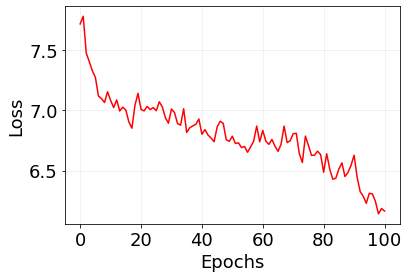

In [108]:
plt.plot(np.array(loss_t), 'r')
#plt.yscale('log')

plt.grid(alpha=.2)


plt.xlabel('Epochs')
plt.ylabel('Loss');

In [736]:
p = params_t[int(np.argmin(np.asarray(loss_t)))]
p = params_t[150]

#### Cmp. loss distributions

#### Div nn viz

In [150]:
#### div
def _div_nn(in_fields):
    mlp = hk.nets.MLP(DIV_HIDDEN+[1],
                      activation=jax.nn.leaky_relu,
                      activate_final=False
                     )
    out = jax.nn.sigmoid(mlp(in_fields))
    return out

_div_nn = hk.without_apply_rng(hk.transform(_div_nn))



#### sec
def _sec_nn(in_fields):
    mlp = hk.nets.MLP(SEC_HIDDEN+[params['n_chem']],
                      activation=jax.nn.leaky_relu,
                      activate_final=False
                     )
    out = jax.nn.sigmoid(mlp(in_fields))
    return out

_sec_nn = hk.without_apply_rng(hk.transform(_sec_nn))

In [151]:
xxx, yyy = np.meshgrid(np.linspace(0,10,30), np.linspace(0,10,30))
#xxx, yyy = np.meshgrid(np.linspace(-20,20,30), np.linspace(-20,20,30))

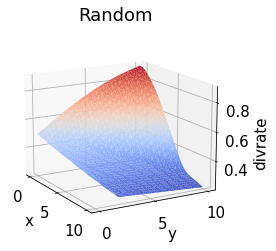

In [152]:
cc = np.vstack((xxx.flatten(),yyy.flatten()))

dd = _div_nn.apply(params['div_fn'], cc.T).flatten()

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
surf = ax.plot_trisurf(cc[0], cc[1], dd, linewidth=.1, antialiased=True, shade=False, cmap=plt.cm.coolwarm)

ax.view_init(15, -30)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('divrate')

ax.set_title('Random');

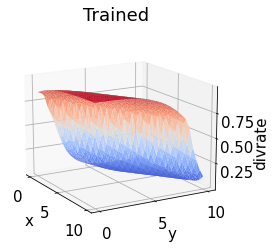

In [153]:
cc = np.vstack((xxx.flatten(),yyy.flatten()))

dd = _div_nn.apply(p['div_fn'], cc.T).flatten()

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
surf = ax.plot_trisurf(cc[0], cc[1], dd, linewidth=.1, antialiased=True, shade=False, cmap=plt.cm.coolwarm)

ax.view_init(15, -30)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('divrate')

ax.set_title('Trained');

In [35]:
params['ncells_add']

78

## Initial params

In [126]:
pp = params.copy()

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, pp, fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, ncells_add=138, key=subkey)

print(METRIC_FN(fstate))

6.628105


In [127]:
fstate.celltype.sum()

Array(140, dtype=int32)

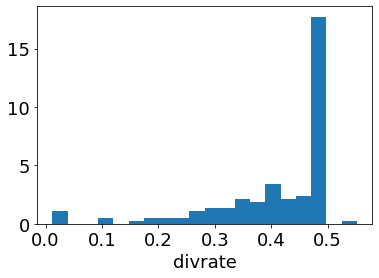

In [128]:
plt.hist(fstate.divrate.tolist(),20,density=True);
plt.xlabel('divrate');

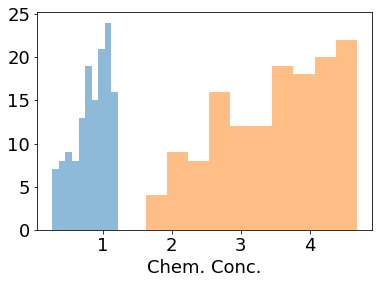

In [129]:
for chem in fstate.chemical.T.tolist():
    plt.hist(chem, alpha=.5);

plt.xlabel('Chem. Conc.');

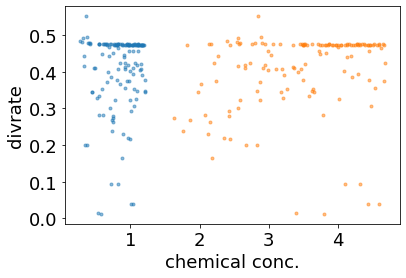

In [130]:
yy = fstate.divrate.tolist()

for chem in fstate.chemical.T.tolist():
    plt.plot(chem, yy, '.', alpha=.5)

plt.ylabel('divrate')
plt.xlabel('chemical conc.');

#plt.legend();

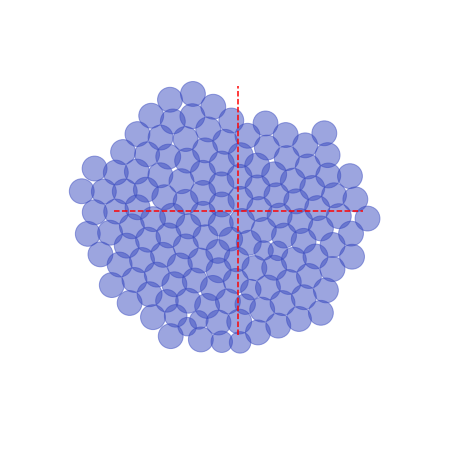

In [131]:
draw_circles_ctype(fstate);

plt.gca().plot([-5.,5.],[0.,0.],'r--');
plt.gca().plot([0.,0.],[-5.,5.],'r--');

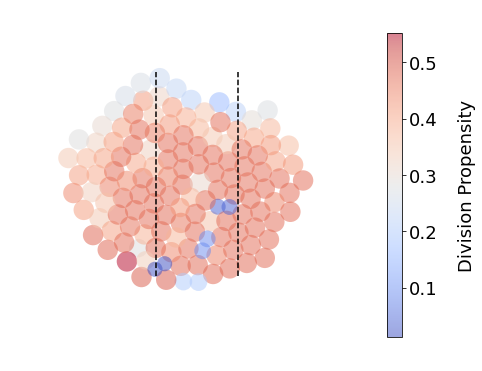

In [132]:
draw_circles_divrate(fstate, probability=False);

lim = 2.

plt.gca().plot([lim,lim],[-5.,5.],'k--');
plt.gca().plot([-lim,-lim],[-5.,5.],'k--');

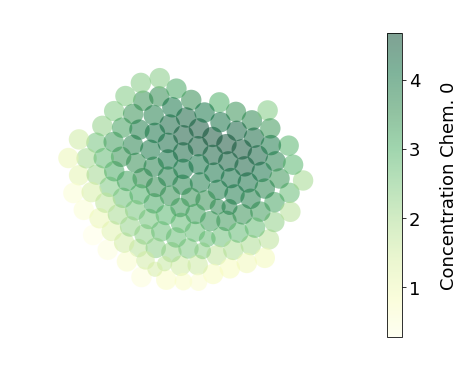

In [133]:
draw_circles_chem(fstate);

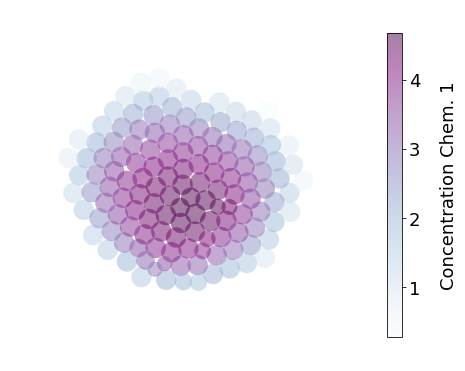

In [134]:
draw_circles_chem(fstate,1);

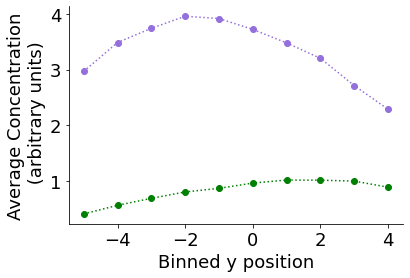

In [135]:
y = np.sort(np.unique(fstate.position[:,1].astype(int))).tolist()
c0y = [float(np.mean(fstate.chemical[:,0][fstate.position[:,1].round().astype(int)==p])) for p in y]
c1y = [float(np.mean(fstate.chemical[:,1][fstate.position[:,1].round().astype(int)==p])) for p in y]



plt.plot(y,c0y,'o:',label='Morphogen 1',color='g')
plt.plot(y,c1y,'o:',label='Morphogen 2',color='mediumpurple')

#plt.grid(alpha=.2)

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)


plt.xlabel('Binned y position')
plt.ylabel('Average Concentration\n (arbitrary units)');

#plt.gcf().savefig('tmp/ychem.rnd.svg')

In [ ]:
x = np.sort(np.unique(fstate.position[:,0].astype(int))).tolist()
c0x = [float(np.mean(fstate.chemical[:,0][fstate.position[:,0].round().astype(int)==p])) for p in x]
c1x = [float(np.mean(fstate.chemical[:,1][fstate.position[:,1].round().astype(int)==p])) for p in x]



plt.plot(x,c0x,'o:',label='Morphogen 1',color='g')
plt.plot(x,c1x,'o:',label='Morphogen 2',color='mediumpurple')

#plt.grid(alpha=.2)

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)


plt.xlabel('Binned x position')
plt.ylabel('Average Concentration\n (arbitrary units)');

#plt.gcf().savefig('tmp/xchem.rnd.svg')

In [138]:
fstate.chemical[:,0]

Array([0.96421826, 0.79519784, 0.8482005 , 1.0080047 , 1.144815  ,
       1.1596483 , 0.87206686, 1.2078574 , 0.9965093 , 0.27322748,
       0.97010666, 0.7925811 , 1.1819277 , 1.2168431 , 0.6065464 ,
       0.9278331 , 0.73861176, 0.604293  , 1.0959516 , 0.9817423 ,
       0.47105497, 1.0614314 , 0.7474854 , 1.1049883 , 0.32940245,
       0.7125207 , 0.58893234, 0.5454999 , 0.7466984 , 1.1682843 ,
       0.31711435, 1.0571432 , 1.1076887 , 0.9961427 , 1.0801082 ,
       1.0272936 , 0.8722022 , 0.80848455, 1.2141615 , 0.67006755,
       0.6877779 , 0.2992546 , 1.1650269 , 0.44428462, 0.7491076 ,
       1.0714874 , 0.35565472, 0.39717388, 0.33135816, 0.70961183,
       0.48538992, 1.0524588 , 0.64362156, 1.1020155 , 1.0088536 ,
       0.70884746, 1.1131146 , 0.9062749 , 1.1501999 , 0.7754373 ,
       0.5420073 , 0.97336376, 0.920583  , 0.3901909 , 0.8219558 ,
       0.632659  , 1.136512  , 0.87933373, 0.6192607 , 0.97686946,
       0.7685043 , 0.4194703 , 0.94446784, 0.97339064, 0.66699

## Trained params

In [110]:
# merge params dicts
all_params = eqx.combine(p, hp)

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, all_params, fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, ncells_add=138, key=subkey)



print(METRIC_FN(fstate))

5.7432795


In [111]:
fstate.celltype.sum()

Array(140, dtype=int32)

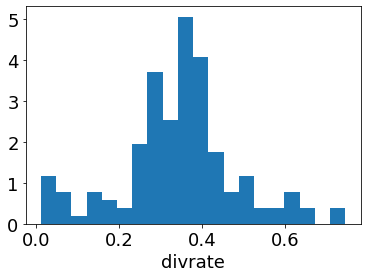

In [112]:
plt.hist(fstate.divrate.tolist(),20,density=True);
plt.xlabel('divrate');

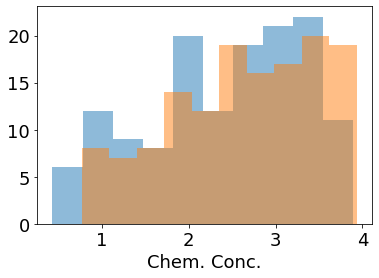

In [113]:
for chem in fstate.chemical.T.tolist():
    plt.hist(chem, alpha=.5);

plt.xlabel('Chem. Conc.');

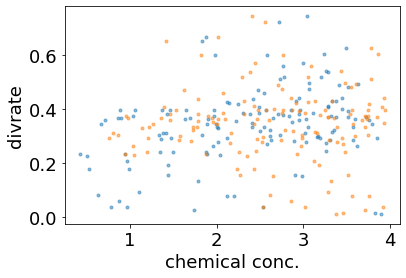

In [114]:
yy = fstate.divrate.tolist()

for chem in fstate.chemical.T.tolist():
    plt.plot(chem, yy, '.', alpha=.5)

plt.ylabel('divrate')
plt.xlabel('chemical conc.');

#plt.legend();

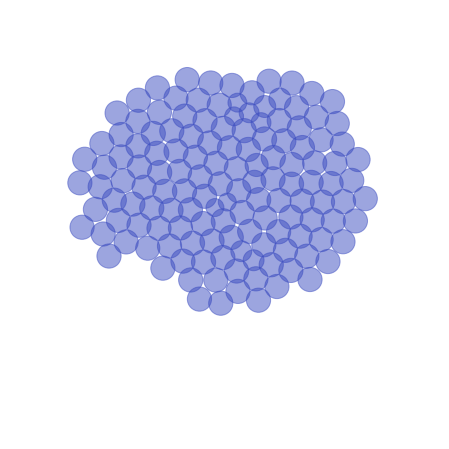

In [115]:
draw_circles_ctype(fstate);
#plt.gca().plot([-5.,5.],[0.,0.],'r--');
#plt.gca().plot([0.,0.],[-5.,5.],'r--');

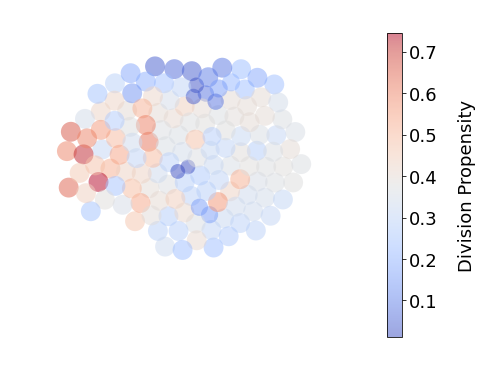

In [124]:
draw_circles_divrate(fstate, probability=False);

lim = 2.

#plt.gca().plot([-5.,5.],[0.,0.],'r--');
#plt.gca().plot([0.,0.],[-5.,5.],'r--');

#plt.gca().plot([lim,lim],[-15.,15.],'k--');
#plt.gca().plot([-lim,-lim],[-15.,15.],'k--');

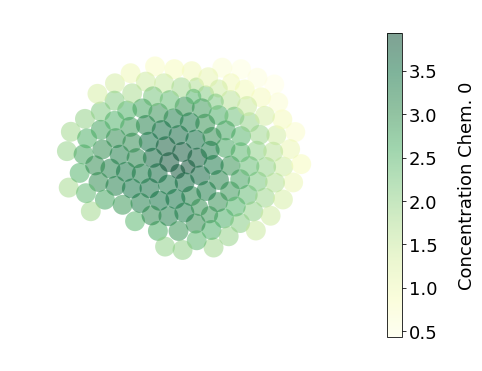

In [117]:
draw_circles_chem(fstate);

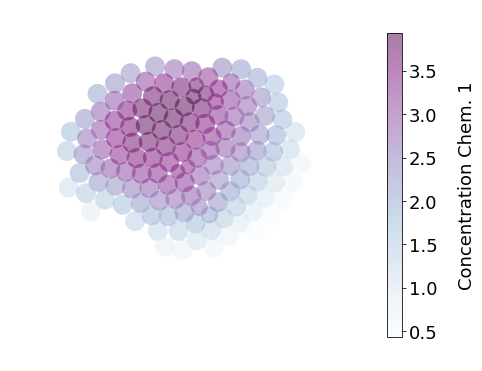

In [118]:
draw_circles_chem(fstate,1);

In [119]:
p['diffCoeff']

Array([0.8879232, 1.211385 ], dtype=float32)

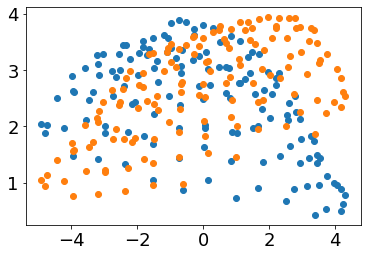

In [120]:
plt.plot(fstate.position[:,1],fstate.chemical[:,0],'o')
plt.plot(fstate.position[:,1],fstate.chemical[:,1],'o')

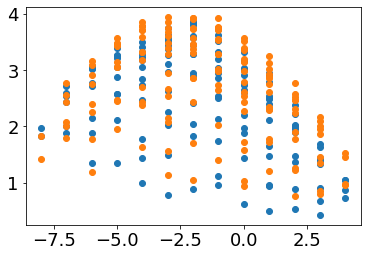

In [121]:
plt.plot(fstate.position[:,0].round().astype(int),fstate.chemical[:,0],'o')
plt.plot(fstate.position[:,0].round().astype(int),fstate.chemical[:,1],'o')

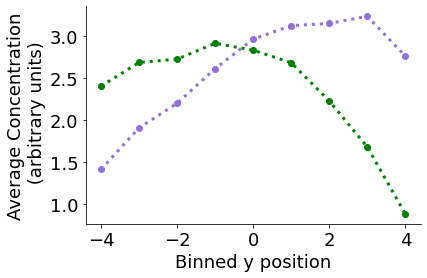

In [122]:
y = np.sort(np.unique(fstate.position[:,1].astype(int))).tolist()
c0y = [float(np.mean(fstate.chemical[:,0][fstate.position[:,1].round().astype(int)==p])) for p in y]
c1y = [float(np.mean(fstate.chemical[:,1][fstate.position[:,1].round().astype(int)==p])) for p in y]


plt.plot(y,c0y,'o:',label='Chem. 1',color='g', linewidth=3)
plt.plot(y,c1y,'o:',label='Chem. 2',color='mediumpurple', linewidth=3)

#plt.grid(alpha=.2)

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)


plt.xlabel('Binned y position')
plt.ylabel('Average Concentration\n (arbitrary units)');


#plt.legend();


#plt.gcf().savefig('tmp/ychem.opt.pdf')

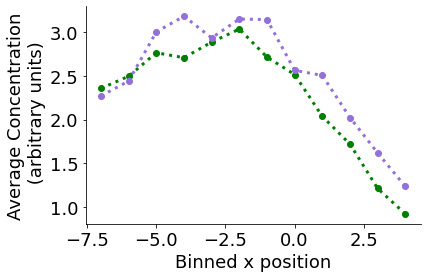

In [123]:
x = np.sort(np.unique(fstate.position[:,0].astype(int))).tolist()
c0x = [float(np.mean(fstate.chemical[:,0][fstate.position[:,0].round().astype(int)==p])) for p in x]
c1x = [float(np.mean(fstate.chemical[:,1][fstate.position[:,0].round().astype(int)==p])) for p in x]



plt.plot(x,c0x,'o:',label='Morphogen 1',color='g', linewidth=3)
plt.plot(x,c1x,'o:',label='Morphogen 2',color='mediumpurple', linewidth=3)

#plt.grid(alpha=.2)

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)


plt.xlabel('Binned x position')
plt.ylabel('Average Concentration\n (arbitrary units)');

#plt.gcf().savefig('tmp/xchem.opt.svg')

## Save GIF

In [278]:
# TRAINED PARAMS
#all_params = eqx.combine(p, hp)

###### OR

#UNTRAINED PARAMS
all_params = params.copy()

In [478]:
ncells_add=ncells_add

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, all_params, fspace)
fstate, (state_t,_) = sim_trajectory(istate, sim_init, sim_step, ncells_add=ncells_add, key=subkey, history=True)



print(METRIC_FN(fstate))

-0.04


In [479]:
st = [sim_init(istate, ncells_add)]+[CellState(*[f[i] for f in jdc.unpack(state_t)]) for i in range(ncells_add)]

In [483]:
#save images
for i in tqdm(list(range(ncells_add+1))):
    
    ax = draw_circles_divrate(st[i])
    
    lim = 2.
    ylim = 6
    
    ax.plot([lim,lim],[-ylim,ylim],'k--');
    ax.plot([-lim,-lim],[-ylim,ylim],'k--');
    
    ax.set_xlim(-ylim,ylim)
    ax.set_ylim(-ylim,ylim)
    
    
    ax.set_aspect('equal', 'box')
    
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    fig=plt.gcf()
    fig.savefig(f'./tmp_gif/img_{i}.png', transparent=False, facecolor='white', edgecolor='white')
    plt.close()

100%|████████████████████████████████████████████████| 49/49 [00:23<00:00,  2.06it/s]


In [484]:
import imageio

frames = []
for i in tqdm(list(range(ncells_add+1))):
    image = imageio.imread(f'./tmp_gif/img_{i}.png')
    frames.append(image)

100%|███████████████████████████████████████████████| 49/49 [00:00<00:00, 410.40it/s]


In [485]:
imageio.mimsave(f'./gifs/tunnel_{ncells_add}cellsadd.gif', # output gif
                frames,          # array of input frames
                fps = 3,
                loop = 1)         # optional: frames per second

# Metric shape tests

In [200]:
def xmask(state):

    mask = (state.position[:,1] > (state.position[:,0]-1)) * (state.position[:,1] < (state.position[:,0]+1))
    mask = mask + (state.position[:,1] > (-state.position[:,0]-1)) * (state.position[:,1] < (-state.position[:,0]+1))
    
    return np.where(mask,-1.,2)*np.where(state.celltype>0,1,0)

In [198]:
def xmask(state):

    mask = (state.position**2).sum(1)<3**2
    
    return np.where(mask,-1.,2)*np.where(state.celltype>0,1,0)

In [105]:
def xmask(state, R=10., width=3.):
    '''
    Costrain cell growth in a circular ring "tunnel".
    '''
    
    X0 = -(R+width/2) #x coord of the center
    
    sum_sq = (state.position[:,0]-X0)**2 + state.position[:,1]**2
    
    mask = (sum_sq>R**2)*(sum_sq<(R+width)**2)
    
    return np.where(mask, -1, 2)*np.where(state.celltype>0,1,0)

In [159]:
def xmask(state):

    mask = (state.position[:,1]>state.position[:,0])*(state.position[:,1]>-state.position[:,0])*(state.position[:,1]<6.)
    
    return np.where(mask, -1, 2)*np.where(state.celltype>0,1,0)

In [213]:
def xmask(state):

    mask = np.bool_((np.abs(state.position[:,0])<1.5)+(np.abs(state.position[:,1])<1.5))    
    
    return np.where(mask, -1, 2)*np.where(state.celltype>0,1,0)

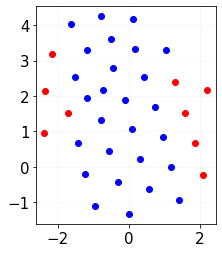

In [106]:
plt.plot(fstate.position[xmask(fstate)>0].T[0].tolist(), fstate.position[xmask(fstate)>0].T[1].tolist(),'ro')
plt.plot(fstate.position[xmask(fstate)<0].T[0].tolist(), fstate.position[xmask(fstate)<0].T[1].tolist(),'bo')

plt.gca().set_aspect('equal')

plt.grid(alpha=.1)

x = np.linspace(-2,5)

#plt.plot(x, x+1)
#plt.plot(x, x-1);

# TESTS